In [1]:
import numpy as np
import sys
import dimod
import matplotlib.pyplot as plt
import os
import re
import neal

from dwave.system import EmbeddingComposite, DWaveSampler
from dwave_qbsolv import QBSolv
from pyqubo import Spin, Array
from embedding_generator import generate_embedding

In [2]:
# Define variable here

# Observed big difference in obtained minimum when increasing the number of reads from 100 to 1000
num_reads = 1000
num_events = 1000
path = '/home/andrea/pythiaEvents/'

theta = np.pi/2.

sampler = EmbeddingComposite(DWaveSampler(solver='Advantage_system1.1'))
sa_sampler = neal.SimulatedAnnealingSampler()

In [13]:
with open('/home/andrea/pythiaEvents/IterRemVarResults_9.dat', 'w') as fout:
    for ev in range(986, num_events):
        print(ev)

        fname = path + 'Event_' + str(ev) + '.dat'
        f = open(fname, 'r')

        pat = re.compile(r"\s+")

        g = list(zip(*[ pat.sub(" ",x.strip()).split() for x in f]))

        px = np.array([ float(x) for x in g[0]])
        py = np.array([ float(x) for x in g[1]])
        pz = np.array([ float(x) for x in g[2]])
        e = np.array([ float(x) for x in g[3]])

        # Generate qubo

        n_part = len(px)
        #print(n_part)
        s = Array.create('s', shape=n_part, vartype='BINARY')

        # Create an array of zeroes for qubo matrix coefficients
        coeff = [[0] * n_part for _ in range(n_part)] 

        for i in range(0,n_part):
            for j in range(0,n_part):
                coeff[i][j] = (px[i]*px[j] +py[i]*py[j] + pz[i]*pz[j] - e[i]*e[j] * np.cos(theta))/(1 - np.cos(theta))

        # Construct Hamiltonian
        H = sum([ -1.0*coeff[i][j]*s[i]*s[j] for i in range(0,n_part) for j in range(0,n_part)])

        # Compile model using pyqubo

        model = H.compile()
        qubo, offset = model.to_qubo()
        bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)

        sum_mom = sum([np.sqrt(px[i]*px[i] + py[i]*py[i]+ pz[i]*pz[i])  for i in range(0,n_part)])

        elite_threshhold = (-1.0*sum_mom*sum_mom)/6.

        new_energy = 0.0

        for j in range(0,10):
            print("Iteration number %s" %j)
            # Submit problem to D-Wave and sample for a relatively small amount of times
            response = sampler.sample(bqm, num_reads=100)
            if (response.first.energy > new_energy): break
            print("Energy: %s" %response.first.energy)
        
            for p in range(n_part):
                key = 's[%s]' %p
                val_list = []
                for datum in response.data(['sample','energy']):
                #For now, lets fix the elite_threshold percentile to have energies at least half of the sum of the momentum in the event.
                    if(datum.energy < elite_threshhold):
                        if(datum.sample[key]): val_list.append(datum.sample[key])
                x = sum(val_list)
                if(x>650):
                    bqm.fix_variable(key, 1)
            new_energy = response.first.energy
        
        thrust = 2.*np.sqrt(-1.*new_energy)/sum_mom
        fout.write("%s  \n" %(thrust)) 


986
Iteration number 0
Energy: -1641.3706485575638
Iteration number 1
987
Iteration number 0
Energy: -1854.426515155068
Iteration number 1
Energy: -1854.9102458584653
Iteration number 2
Energy: -1862.391234139178
Iteration number 3
988
Iteration number 0
Energy: -902.811753792658
Iteration number 1
989
Iteration number 0
Energy: -1271.6985471948879
Iteration number 1
990
Iteration number 0
Energy: -1951.344969392595
Iteration number 1
Energy: -1951.344969392595
Iteration number 2
Energy: -1951.456208646769
Iteration number 3
Energy: -1951.456208646769
Iteration number 4
991
Iteration number 0
Energy: -1284.3460892683333
Iteration number 1
992
Iteration number 0
Energy: -1989.0863235498143
Iteration number 1
Energy: -1989.0863235498143
Iteration number 2
993
Iteration number 0
Energy: -1852.9723225769903
Iteration number 1
994
Iteration number 0
Energy: -1863.218988071506
Iteration number 1
Energy: -1864.9939185999128
Iteration number 2
995
Iteration number 0
Energy: -1245.5087337698637

In [90]:
thrust = 2.*np.sqrt(804.854241068897)/sum_mom
print(thrust)

0.625597623042203


In [45]:
#SPVAR Algorithm

# - Obtain a sample of sample_size from the sampler
# - Narrow down the solutions to the elite_threshhold percentile
# - Find the mean value of each variable in all solutions
# - Fix the variables for which the mean absolute value is larger than fixing_threshold
# - Update J and h

mean_val = {}
print(-1.0*sum_mom*sum_mom/8.)
elite_threshhold = (-1.0*sum_mom*sum_mom)/6.

for p in range(n_part):
    key = 's[%s]' %p
    val_list = []
    for datum in response.data(['sample','energy']):
        #print(datum.energy)
        #For now, lets fix the elite_threshold percentile to have energies at least half of the sum of the momentum in the event.
        if(datum.energy < elite_threshhold):
            val_list.append(datum.sample[key])
            #f.write("%s\n" %(response.first.sample[key]))
    mean_val[key] = val_list 


-1032.081450522637


In [3]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [5]:
pat = re.compile(r"\s+")
f = open("/Users/1zd/quantumjets/pythiaEvents/Pythia8Results.dat", 'r')

In [6]:
g = list(zip(*[ pat.sub(" ",x.strip()).split() for x in f]))

In [7]:
npart = np.array([ int(x) for x in g[0]])
sph = np.array([ float(x) for x in g[1]]) #thrust calculated using sphericity as seed axis
thr = np.array([ float(x) for x in g[2]])
niter = np.array([ int(x) for x in g[3]])

In [9]:
pat2 = re.compile(r"\s+")
fd = open("/Users/1zd/quantumjets/pythiaEvents/IterRemVarResults.dat", 'r')

In [10]:
g2 = list(zip(*[ pat2.sub(" ",x.strip()).split() for x in fd]))

In [11]:
it = np.array([ float(x) for x in g2[0]])

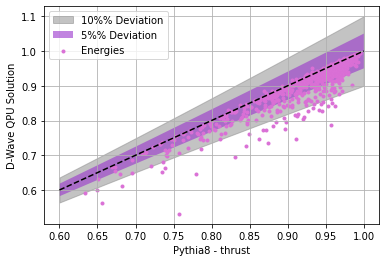

In [13]:
fig, ax = plt.subplots()
x_data = np.linspace(0.6, 1.0, 10)

a = list(zip(x_data, x_data))
sigma = 0.1

lower_bound = []
upper_bound = []
lower_bound5 = []
upper_bound5 = []

for i in range(len(x_data)):
    lower_bound.append(x_data[i]*(1-sigma*x_data[i]))
    upper_bound.append(x_data[i]*(1+sigma*x_data[i]))
    lower_bound5.append(x_data[i]*(1-0.05*x_data[i]))
    upper_bound5.append(x_data[i]*(1+0.05*x_data[i]))

ax.grid()

#ax.fill_between(x_data, lower_bound, upper_bound, facecolor='yellow', alpha=0.5,label='10%% Deviation')
#ax.fill_between(x_data, lower_bound5, upper_bound5, facecolor='green', alpha=0.5,label='5%% Deviation')
#ax.plot(x_data,x_data, color='black', ls='--', label='Linear relationship')
#ax.scatter(thr, it, color='red', label='Data')

ax.fill_between(x_data, lower_bound, upper_bound, alpha=0.5, edgecolor='#888888', facecolor='#888888', label='10%% Deviation')
ax.fill_between(x_data, lower_bound5, upper_bound5, facecolor='darkorchid', alpha=0.6,label='5%% Deviation')
ax.plot(x_data,x_data, color='black', ls='--')
ax.scatter(thr, it, color='orchid', marker = '.', label='Energies')
#plt.plot(x_data, lower_bound, color='black',ls='--')
ax.set_xlabel('Pythia8 - thrust')
ax.set_ylabel('D-Wave QPU Solution')
ax.legend(loc='upper left')

plt.savefig('plots/iter_removal.png')
plt.show()
